In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
from graphreg_tf2 import (
    SeqCNN, 
    GraphReg,
    poisson_loss,
    seq_cnn_base, 
    PearsonCorrelation, 
    read_tf_record_1shot, 
    GraphAttention,
    dataset_iterator
)
data_dir = '/pollard/home/sandyfloren/hierarchical/data/graphreg_data/tfr/k562_50000'
seq_cnn_pretrained_weights = '/pollard/home/sandyfloren/hierarchical/bin/GraphReg_repo/models/K562/Seq-CNN_base_K562_valid_chr_3,13_test_chr_4,14.h5'
seq_graphreg_pretrained_weights = '/pollard/home/sandyfloren/hierarchical/bin/GraphReg_repo/models/K562/Seq-GraphReg_K562_HiChIP_FDR_1_valid_chr_3,13_test_chr_4,14.h5'


2024-09-10 12:14:14.605318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 12:14:14.605385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 12:14:14.606179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 12:14:14.611389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pyfaidx

hg38_fa = pyfaidx.Fasta('/pollard/data/vertebrate_genomes/human/hg38/hg38/hg38.fa')
hg19_fa = pyfaidx.Fasta('/pollard/data/vertebrate_genomes/human/hg19/hg19/hg19.fa')


In [25]:
seq_hg38 = hg38_fa.get_seq('chr19', 10_000_000, 16_000_000).seq.upper()
seq_hg19 = hg19_fa.get_seq('chr19', 10_000_000, 16_000_000).seq.upper()


{'A', 'C', 'G', 'T'}

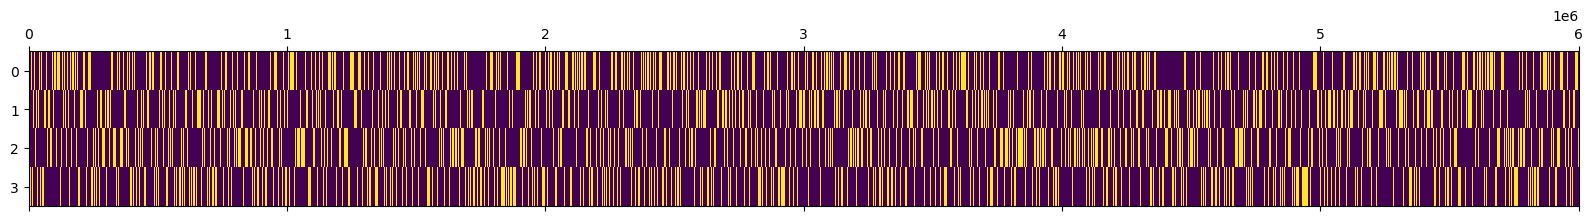

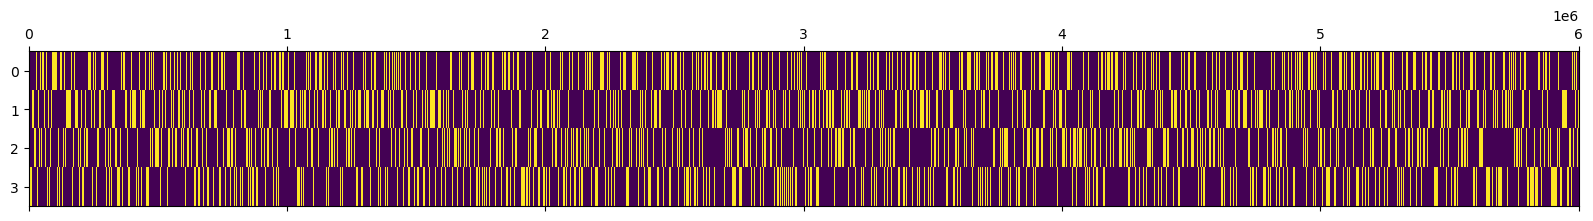

In [39]:
from tangermeme.utils import one_hot_encode

diff = one_hot_encode(seq_hg38) - one_hot_encode(seq_hg19)



plt.figure(figsize=(20,2))
plt.matshow(one_hot_encode(seq_hg38), aspect='auto', fignum=1)
plt.show()

plt.figure(figsize=(20,2))
plt.matshow(one_hot_encode(seq_hg19), aspect='auto', fignum=1)
plt.show()

# Seq-CNN

# Seq-GraphReg

tf.Tensor(-0.034352485, shape=(), dtype=float32)


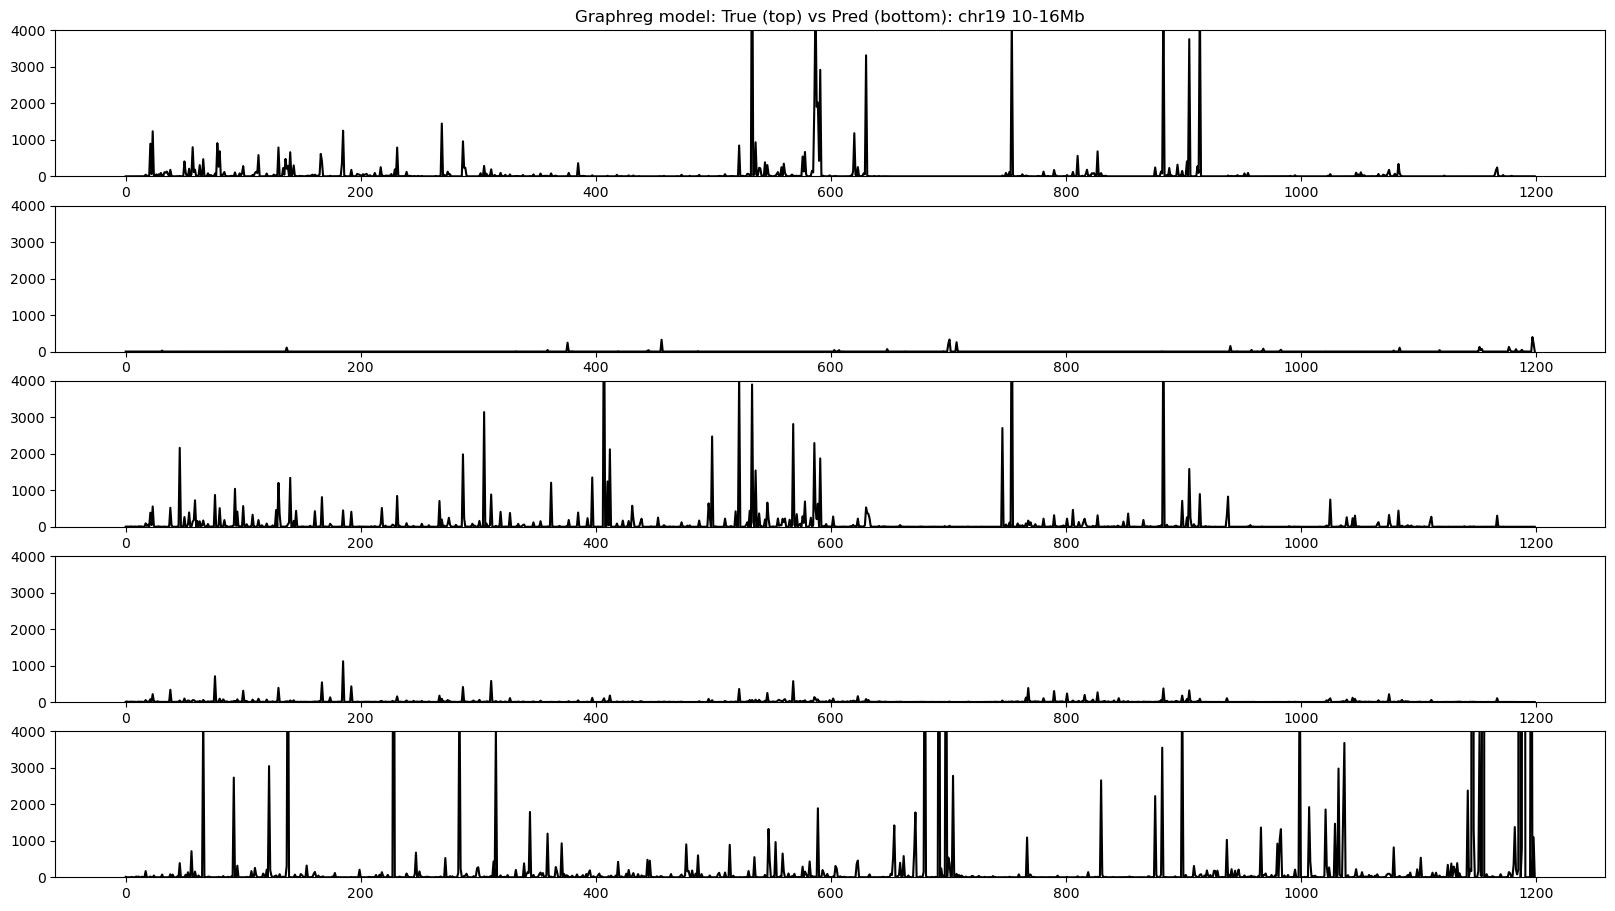

tf.Tensor(947.5333, shape=(), dtype=float32)
tf.Tensor(94.94134, shape=(), dtype=float32)
tf.Tensor(159.16315, shape=(), dtype=float32)
tf.Tensor(873.06726, shape=(), dtype=float32)


In [10]:
chr = 'chr19'
i = 0
iterator_train = dataset_iterator(os.path.join(data_dir, f'{chr}.tfr'), batch_size=1)
model_graphreg = GraphReg()
model_graphreg([tf.zeros((1, 60_000, 64), dtype=tf.float32), tf.zeros((1200, 1200), dtype=tf.float32)])
model_graphreg.load_weights('/pollard/home/sandyfloren/hierarchical/bin/graphreg_tf2/weights/seq_graphreg/k562/seq-graphreg-pretrained-cnn-base_val_3_13_test_4_14_validloss=26.92.h5')

model_graphreg_pretrained = tf.keras.models.load_model(seq_graphreg_pretrained_weights, custom_objects={"GraphAttention": GraphAttention})
model_graphreg_pretrained.trainable = False

model_cnn_base = SeqCNN()
model_cnn_base(tf.zeros((1, 100000, 4), dtype=tf.float32))
model_cnn_base.load_weights('/pollard/home/sandyfloren/hierarchical/bin/graphreg_tf2/weights/seq_cnn_base/k562/base-0.1-black-pct_val_3_13_test_4_14_validloss=18.09.h5')

model_cnn_base_pretrained = tf.keras.models.load_model(seq_cnn_pretrained_weights)
model_cnn_base_pretrained.trainable = False

cage_window_true = []
cage_window_pred = []
cage_window_pred_pretrained_cnn = []
cage_window_pred_pretrained_both = []
cage_window_pred_pretrained_gat_only = []

seqs = []

pearson = PearsonCorrelation(name='pearsonr')

for item_idx, item in enumerate(iterator_train):
    if item_idx not in [4,5,6]: continue
    data_exist, seq, Y, adj, Y_h3k4me3, Y_h3k27ac, Y_dnase, idx, tss_idx = read_tf_record_1shot(item)
    
    H = []
    H_pretrained = []
    for jj in range(0, 60, 10):
        seq_batch = seq[jj : jj + 10]
        _, _, _, h = model_cnn_base(seq_batch)
        H.append(h)
        _, _, _, h_pretrained = model_cnn_base_pretrained(seq_batch)
        H_pretrained.append(h_pretrained)

    x_in_gat = K.concatenate(H, axis=0)
    x_in_gat = K.reshape(x_in_gat, [1, 60000, 64])

    x_in_gat_pretrained = K.concatenate(H_pretrained, axis=0)
    x_in_gat_pretrained = K.reshape(x_in_gat_pretrained, [1, 60000, 64])

    pred, att_mats = model_graphreg([x_in_gat, adj], training=False)
    att1, att2, att3 = att_mats

    pred_pretrained_cnn, att_mats_pretrained = model_graphreg([x_in_gat_pretrained, adj], training=False)

    pred_pretrained_both, att_mats_pretrained = model_graphreg_pretrained([x_in_gat_pretrained, adj], training=False)

    pred_pretrained_gat_only, _ = model_graphreg_pretrained([x_in_gat, adj], training=False)

    Y_cage = tf.squeeze(Y[:, 400:800])
    Y_hat_cage = tf.squeeze(pred[:, 400:800])
    Y_hat_cage_pretrained_cnn = tf.squeeze(pred_pretrained_cnn[:, 400:800])
    Y_hat_cage_pretrained_both = tf.squeeze(pred_pretrained_both[:, 400:800])
    Y_hat_cage_pretrained_gat_only = tf.squeeze(pred_pretrained_gat_only[:, 400:800])

    cage_window_true.append(Y_cage)
    cage_window_pred.append(Y_hat_cage)
    cage_window_pred_pretrained_cnn.append(Y_hat_cage_pretrained_cnn)
    cage_window_pred_pretrained_both.append(Y_hat_cage_pretrained_both)
    cage_window_pred_pretrained_gat_only.append(Y_hat_cage_pretrained_gat_only)

    #seqs.append(seq[2_000_000:4_000_000])
    pearson.update_state(tf.math.log1p(tf.squeeze(Y_cage)), tf.math.log1p(tf.squeeze(Y_hat_cage)))
    
print(pearson.result())
fig, axs = plt.subplots(5, 1)
fig.set_figheight(11)
fig.set_figwidth(20)
axs[0].set_title(f'Graphreg model: True (top) vs Pred (bottom): {chr} 10-16Mb')
axs[0].plot(tf.concat(cage_window_true, axis=0), color='black')
axs[1].plot(tf.concat(cage_window_pred, axis=0), color='black')
axs[2].plot(tf.concat(cage_window_pred_pretrained_cnn, axis=0), color='black')
axs[3].plot(tf.concat(cage_window_pred_pretrained_both, axis=0), color='black')
axs[4].plot(tf.concat(cage_window_pred_pretrained_gat_only, axis=0), color='black')
axs[0].set_ylim(0, 4000)
axs[1].set_ylim(0, 4000)
axs[2].set_ylim(0, 4000)
axs[3].set_ylim(0, 4000)
axs[4].set_ylim(0, 4000)
plt.show()

#plt.figure(figsize=(20,2))
#plt.matshow(tf.concat(seqs, axis=0).numpy().T, aspect='auto', fignum=1)
#plt.show()
print(poisson_loss(
    tf.concat(cage_window_true, axis=0),
    tf.concat(cage_window_pred, axis=0)
))
print(poisson_loss(
    tf.concat(cage_window_true, axis=0),
    tf.concat(cage_window_pred_pretrained_cnn, axis=0)
))
print(poisson_loss(
    tf.concat(cage_window_true, axis=0),
    tf.concat(cage_window_pred_pretrained_both, axis=0)
))

print(poisson_loss(
    tf.concat(cage_window_true, axis=0),
    tf.concat(cage_window_pred_pretrained_gat_only, axis=0)
))



tf.Tensor(0.44598594, shape=(), dtype=float32)
tf.Tensor(0.48080978, shape=(), dtype=float32)
tf.Tensor(0.532104, shape=(), dtype=float32)


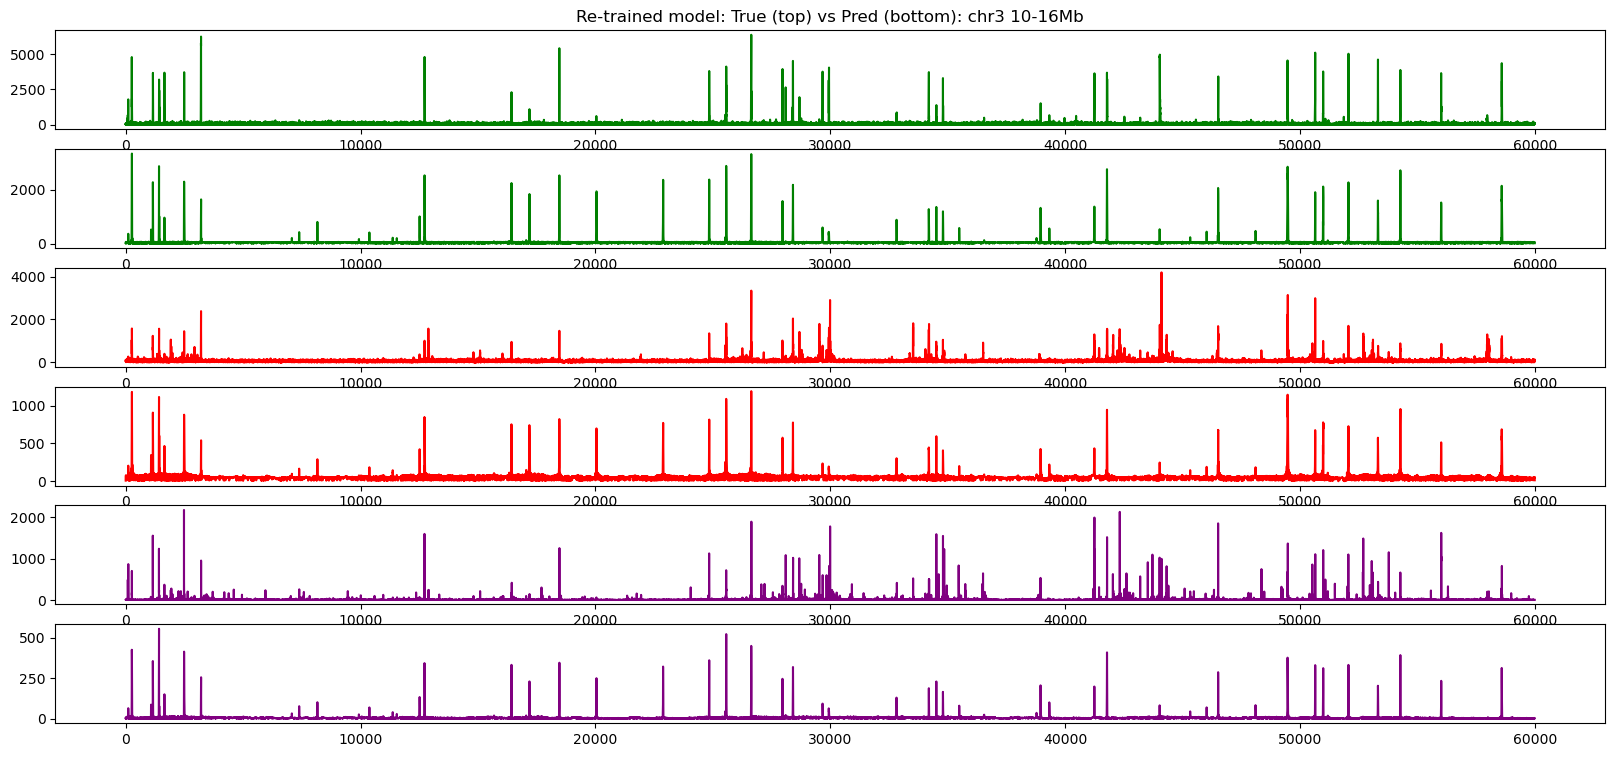

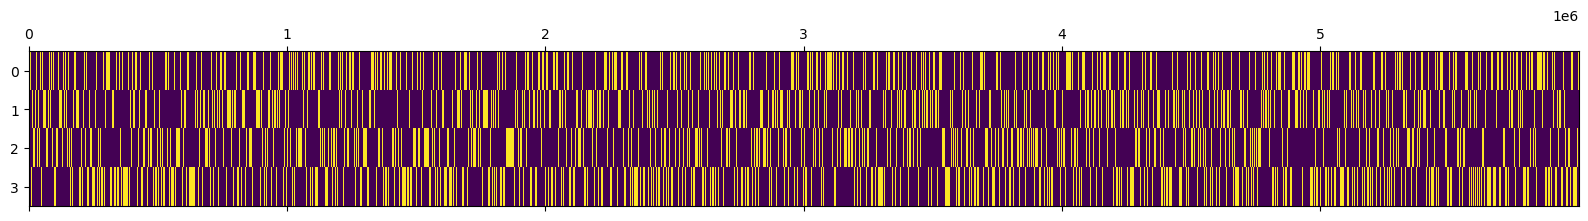

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from graphreg_tf2 import SeqCNN, poisson_loss, seq_cnn_base #pearsonr
from scipy.stats import pearsonr
chr = 'chr3'
i = 0
iterator_train = dataset_iterator(os.path.join(data_dir, f'{chr}.tfr'), batch_size=1)
model_cnn_base = SeqCNN()
model_cnn_base(tf.zeros((1, 100000, 4), dtype=tf.float32))
model_cnn_base.load_weights('/pollard/home/sandyfloren/hierarchical/bin/graphreg_tf2/weights/seq_cnn_base/k562/base-0.1-black-pct_val_3_13_test_4_14_validloss=18.09.h5')


h3k4me3_window_true = []
h3k27ac_window_true = []
dnase_window_true = []

h3k4me3_window_pred = []
h3k27ac_window_pred = []
dnase_window_pred = []

seqs = []

pearson_h3k4me3 = PearsonCorrelation()
pearson_h3k27ac = PearsonCorrelation()
pearson_dnase = PearsonCorrelation()

for item_idx, item in enumerate(iterator_train):
    if item_idx not in [4,5,6]: continue
    data_exist, seq, Y, adj, Y_h3k4me3, Y_h3k27ac, Y_dnase, idx, tss_idx = read_tf_record_1shot(item)

    for i in range(20,40):
        seq_tfr = seq[i]

        Y_hat_h3k4me3, Y_hat_h3k27ac, Y_hat_dnase, _ = model_cnn_base(tf.reshape(seq_tfr, (1, 100000, 4)), training=False)

        h3k4me3_window_true.append(Y_h3k4me3[i])
        h3k27ac_window_true.append(Y_h3k27ac[i])
        dnase_window_true.append(Y_dnase[i])

        h3k4me3_window_pred.append(Y_hat_h3k4me3[0])
        h3k27ac_window_pred.append(Y_hat_h3k27ac[0])
        dnase_window_pred.append(Y_hat_dnase[0])

        seqs.append(seq_tfr)

        pearson_h3k4me3.update_state(tf.math.log1p(tf.squeeze(Y_h3k4me3[i])), tf.math.log1p(tf.squeeze(Y_hat_h3k4me3)))
        pearson_h3k27ac.update_state(tf.math.log1p(tf.squeeze(Y_h3k27ac[i])), tf.math.log1p(tf.squeeze(Y_hat_h3k27ac)))
        pearson_dnase.update_state(tf.math.log1p(tf.squeeze(Y_dnase[i])), tf.math.log1p(tf.squeeze(Y_hat_dnase)))
       
print(pearson_h3k4me3.result())
print(pearson_h3k27ac.result())
print(pearson_dnase.result())
fig, axs = plt.subplots(6, 1)
fig.set_figheight(9)
fig.set_figwidth(20)
axs[0].set_title(f'Re-trained model: True (top) vs Pred (bottom): {chr} 10-16Mb')
axs[0].plot(tf.concat(h3k4me3_window_true, axis=0), color='green')
axs[1].plot(tf.concat(h3k4me3_window_pred, axis=0), color='green')

axs[2].plot(tf.concat(h3k27ac_window_true, axis=0), color='red')
axs[3].plot(tf.concat(h3k27ac_window_pred, axis=0), color='red')

axs[4].plot(tf.concat(dnase_window_true, axis=0), color='purple')
axs[5].plot(tf.concat(dnase_window_pred, axis=0), color='purple')
#axs[1, 0].sharey(axs[0, 0])
#axs[1, 1].sharey(axs[0, 1])
#axs[1, 2].sharey(axs[0, 2])
plt.show()

plt.figure(figsize=(20,2))
plt.matshow(tf.concat(seqs, axis=0).numpy().T, aspect='auto', fignum=1)
plt.show()


In [ ]:
seq[20:21][:, 0:10, :]

tf.Tensor(0.31882128, shape=(), dtype=float32)
tf.Tensor(0.2601723, shape=(), dtype=float32)
tf.Tensor(0.5375832, shape=(), dtype=float32)


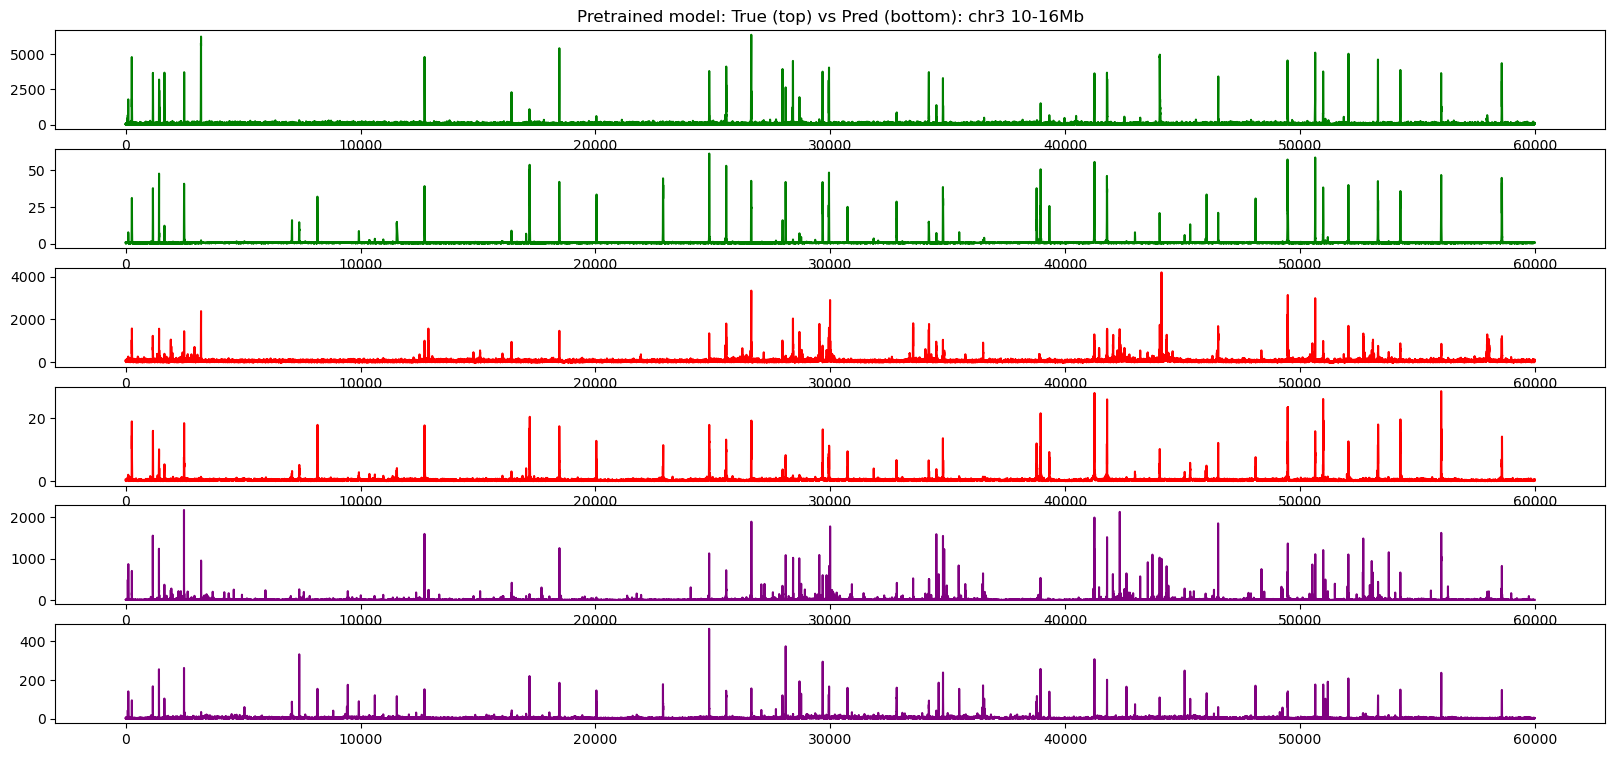

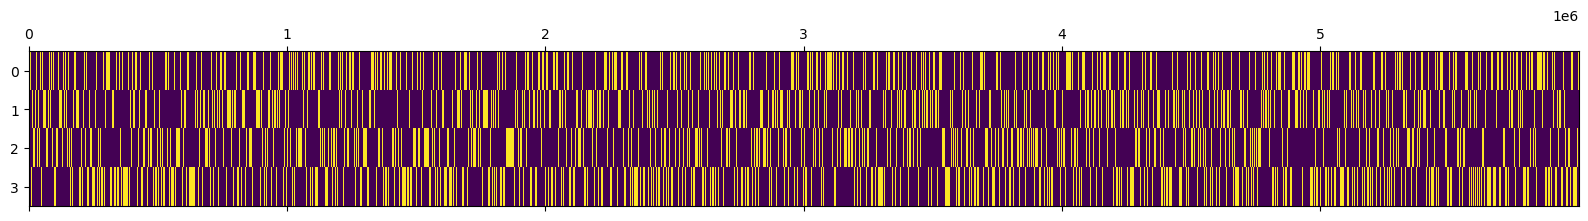

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from graphreg_tf2 import poisson_loss

chr = 'chr3'
i = 0
iterator_train = dataset_iterator(os.path.join(data_dir, f'{chr}.tfr'), batch_size=1)
base = 'Seq-CNN_base_K562_valid_chr_3,13_test_chr_4,14'
base_fft = 'Seq-CNN_base_fft_K562_valid_chr_3,13_test_chr_4,14'
nodilation = 'Seq-CNN_base_nodilation_K562_valid_chr_3,13_test_chr_4,14'
nodilation_fft = 'Seq-CNN_base_nodilation_fft_K562_valid_chr_3,13_test_chr_4,14'

model_pretrained = tf.keras.models.load_model(f'/pollard/home/sandyfloren/hierarchical/bin/GraphReg_repo/models/K562/{base}.h5')
#model_cnn_base(tf.zeros((1, 100000, 4), dtype=tf.float32))
#model_cnn_base.load_weights('/pollard/home/sandyfloren/hierarchical/bin/graphreg_tf2/weights/seq_cnn_base/k562/seq-cnn-base-batchsize-20-revcomp-batch-shuffle_val_3_13_test_4_14_validloss=31.51.h5')

h3k4me3_window_true = []
h3k27ac_window_true = []
dnase_window_true = []

h3k4me3_window_pred = []
h3k27ac_window_pred = []
dnase_window_pred = []

seqs = []



pearson_h3k4me3 = PearsonCorrelation()
pearson_h3k27ac = PearsonCorrelation()
pearson_dnase = PearsonCorrelation()

for item_idx, item in enumerate(iterator_train):
    if item_idx not in [4, 5, 6]: continue
    data_exist, seq, Y, adj, Y_h3k4me3, Y_h3k27ac, Y_dnase, idx, tss_idx = read_tf_record_1shot(item)
    h3k4me3_window = tf.reshape(Y_h3k4me3, [60000])
    h3k27ac_window = tf.reshape(Y_h3k27ac, [60000])
    dnase_window = tf.reshape(Y_dnase, [60000])


    for i in range(20,40):
        seq_tfr = seq[i]

        Y_hat_h3k4me3, Y_hat_h3k27ac, Y_hat_dnase, _ = model_pretrained(tf.reshape(seq_tfr, (1, 100000, 4)), training=False)

        h3k4me3_window_true.append(Y_h3k4me3[i])
        h3k27ac_window_true.append(Y_h3k27ac[i])
        dnase_window_true.append(Y_dnase[i])

        h3k4me3_window_pred.append(Y_hat_h3k4me3[0])
        h3k27ac_window_pred.append(Y_hat_h3k27ac[0])
        dnase_window_pred.append(Y_hat_dnase[0])

        seqs.append(seq_tfr)

        pearson_h3k4me3.update_state(tf.math.log1p(tf.squeeze(Y_h3k4me3[i])), tf.math.log1p(tf.squeeze(Y_hat_h3k4me3)))
        pearson_h3k27ac.update_state(tf.math.log1p(tf.squeeze(Y_h3k27ac[i])), tf.math.log1p(tf.squeeze(Y_hat_h3k27ac)))
        pearson_dnase.update_state(tf.math.log1p(tf.squeeze(Y_dnase[i])), tf.math.log1p(tf.squeeze(Y_hat_dnase)))
       
print(pearson_h3k4me3.result())
print(pearson_h3k27ac.result())
print(pearson_dnase.result())
fig, axs = plt.subplots(6, 1)
fig.set_figheight(9)
fig.set_figwidth(20)
axs[0].set_title(f'Pretrained model: True (top) vs Pred (bottom): {chr} 10-16Mb')
axs[0].plot(tf.concat(h3k4me3_window_true, axis=0), color='green')
axs[1].plot(tf.concat(h3k4me3_window_pred, axis=0), color='green')

axs[2].plot(tf.concat(h3k27ac_window_true, axis=0), color='red')
axs[3].plot(tf.concat(h3k27ac_window_pred, axis=0), color='red')

axs[4].plot(tf.concat(dnase_window_true, axis=0), color='purple')
axs[5].plot(tf.concat(dnase_window_pred, axis=0), color='purple')
#axs[1, 0].sharey(axs[0, 0])
#axs[1, 1].sharey(axs[0, 1])
#axs[1, 2].sharey(axs[0, 2])
plt.show()

plt.figure(figsize=(20,2))
plt.matshow(tf.concat(seqs, axis=0).numpy().T, aspect='auto', fignum=1)
plt.show()



In [ ]:
import matplotlib.pyplot as plt
chr = 'chr19'
iterator_train = dataset_iterator(f'/pollard/home/sandyfloren/hierarchical/data/graphreg_data/tfr/k562/{chr}.tfr', batch_size=1)

for item_idx, item in enumerate(iterator_train):
    if item_idx != 5: continue # get 
    data_exist, seq, Y, Y_h3k4me3, Y_h3k27ac, Y_dnase, idx, tss_idx = read_tf_record_1shot(item)
    h3k4me3_window = tf.reshape(Y_h3k4me3, [60000])
    h3k27ac_window = tf.reshape(Y_h3k27ac, [60000])
    dnase_window = tf.reshape(Y_dnase, [60000])

    fig, axs = plt.subplots(3, 1)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    axs[0].plot(h3k4me3_window, color='green')
    axs[1].plot(h3k27ac_window, color='red')
    axs[2].plot(dnase_window, color='purple')
    axs[0].title.set_text('My raw data: chr19: 10-16 Mb')


In [ ]:
n_seqs_dict = {}
indices_dict = {}
chr_list = []
seqs_bed_file = "/pollard/home/sandyfloren/hierarchical/data/graphreg_data/seqs/windows_6Mb_no_gaps.bed"
i = 0
for line in open(seqs_bed_file):

    a = line.split()
    if a[0] not in chr_list:
        chr_list.append(a[0])
        n_seqs_dict[a[0]] = 1
        indices_dict[a[0]] = [i, i+1]
    else:
        n_seqs_dict[a[0]] += 1
        indices_dict[a[0]][1] += 1
    i += 1

print(n_seqs_dict)
print(indices_dict)

In [ ]:
import matplotlib.pyplot as plt
import pyBigWig
import h5py

cage_bw = pyBigWig.open('/pollard/home/sandyfloren/hierarchical/data/encode/cage/k562_cage.bw')
h3k4me4_bw = pyBigWig.open('/pollard/home/sandyfloren/hierarchical/data/encode/h3k4me3/k562_h3k4me3.bw')
h3k27ac_bw = pyBigWig.open('/pollard/home/sandyfloren/hierarchical/data/encode/h3k27ac/k562_h3k27ac.bw')
dnase_bw = pyBigWig.open('/pollard/home/sandyfloren/hierarchical/data/encode/dnase/k562_dnase.bw')

old_h3k4me4_bw = pyBigWig.open('/pollard/home/sandyfloren/hierarchical/data/encode/h3k4me3/old_k562_h3k4me3.bw')
old_h3k27ac_bw = pyBigWig.open('/pollard/home/sandyfloren/hierarchical/data/encode/h3k27ac/old_k562_h3k27ac.bw')
old_dnase_bw = pyBigWig.open('/pollard/home/sandyfloren/hierarchical/data/encode/dnase/old_k562_dnase.bw')





In [ ]:


cage_raw = cage_bw.values('chr19', 10_000_000, 16_000_000)
h3k4me3_raw = h3k4me4_bw.values('chr19', 10_000_000, 16_000_000)
h3k27ac_raw = h3k27ac_bw.values('chr19', 10_000_000, 16_000_000)
dnase_raw = dnase_bw.values('chr19', 10_000_000, 16_000_000)

old_h3k4me3_raw = old_h3k4me4_bw.values('chr19', 10_000_000, 16_000_000)
old_h3k27ac_raw = old_h3k27ac_bw.values('chr19', 10_000_000, 16_000_000)
old_dnase_raw = old_dnase_bw.values('chr19', 10_000_000, 16_000_000)


fig, axs = plt.subplots(4, 1)
fig.set_figheight(7)
fig.set_figwidth(20)
axs[0].plot(cage_raw, color='black')
axs[1].plot(h3k4me3_raw, color='green')
axs[2].plot(h3k27ac_raw, color='red')
axs[3].plot(dnase_raw, color='purple')
axs[0].title.set_text('Controlled bigwig data: chr19: 10-16 Mb')
plt.show()
fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(old_h3k4me3_raw, color='green')
axs[1].plot(old_h3k27ac_raw, color='red')
axs[2].plot(old_dnase_raw, color='purple')
axs[0].title.set_text('Uncontrolled bigwig data: chr19: 10-16 Mb')
plt.show()

In [ ]:
dnase_raw_h5.min()

In [ ]:
import h5py 

cage_h5 = h5py.File('/pollard/home/sandyfloren/hierarchical/data/graphreg_data/1d/k562/cage.h5')
h3k4me4_h5 = h5py.File('/pollard/home/sandyfloren/hierarchical/data/graphreg_data/1d/k562/h3k4me3.h5')
h3k27ac_h5 = h5py.File('/pollard/home/sandyfloren/hierarchical/data/graphreg_data/1d/k562/h3k27ac.h5')
dnase_h5 = h5py.File('/pollard/home/sandyfloren/hierarchical/data/graphreg_data/1d/k562/dnase.h5')

cage_raw_h5 = cage_h5['targets'][indices_dict['chr19'][0]:indices_dict['chr19'][1]][5]
h3k4me3_raw_h5 = h3k4me4_h5['targets'][indices_dict['chr19'][0]:indices_dict['chr19'][1]][5]
h3k27ac_raw_h5 = h3k27ac_h5['targets'][indices_dict['chr19'][0]:indices_dict['chr19'][1]][5]
dnase_raw_h5 = dnase_h5['targets'][indices_dict['chr19'][0]:indices_dict['chr19'][1]][5]

fig, axs = plt.subplots(4, 1)
fig.set_figheight(7)
fig.set_figwidth(20)
axs[0].plot(cage_raw_h5, color='black')
axs[1].plot(h3k4me3_raw_h5, color='green')
axs[2].plot(h3k27ac_raw_h5, color='red')
axs[3].plot(dnase_raw_h5, color='purple')
axs[0].title.set_text('Raw h5 data: chr19: 10-16 Mb')

In [ ]:
cage_h5_raw = cage_h5['targets'][indices_dict['chr19'][0]:indices_dict['chr19'][1]][5]

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(cage_h5_raw, color='black')
axs[1].plot(cage_h5_raw, color='black')
plt.title('Raw h5 data: chr19: 10-16 Mb')

In [ ]:
all_pred_h3k4me3 = tf.concat(pred_h3k4me3, axis=0)
all_pred_h3k27ac = tf.concat(pred_h3k27ac, axis=0)
all_pred_dnase = tf.concat(pred_dnase, axis=0)

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(all_pred_h3k4me3, color='green')
axs[1].plot(all_pred_h3k27ac, color='red')
axs[2].plot(all_pred_dnase, color='purple')
axs[0].title.set_text('Pretrained model preds: chr19: 10-16 Mb')

In [ ]:
tf.keras.utils.plot_model(model_cnn_base)

In [ ]:
tf.keras.utils.plot_model(model_pretrained)

In [ ]:
model_pretrained.layers[-6].weights[0]

In [ ]:
import matplotlib.pyplot as plt

base = 'Seq-CNN_base_K562_valid_chr_3,13_test_chr_4,14'
base_fft = 'Seq-CNN_base_fft_K562_valid_chr_3,13_test_chr_4,14'
nodilation = 'Seq-CNN_base_nodilation_K562_valid_chr_3,13_test_chr_4,14'
nodilation_fft = 'Seq-CNN_base_nodilation_fft_K562_valid_chr_3,13_test_chr_4,14'

model_pretrained = tf.keras.models.load_model(f'/pollard/home/sandyfloren/hierarchical/bin/GraphReg_repo/models/K562/{base}.h5')
model_trained = tf.keras.models.load_model(f'/pollard/home/sandyfloren/hierarchical/bin/graphreg_tf2/weights/seq_cnn_base/models/k562/Seq-CNN_base_k562_valid_chr_3,13_test_chr_4,14.h5')


plt.imshow(model_pretrained.layers[-6].weights[0])
plt.show()
plt.imshow(model_trained.layers[-6].weights[0])
plt.show()

plt.imshow(model_pretrained.layers[-5].weights[0])
plt.show()
plt.imshow(model_trained.layers[-5].weights[0])
plt.show()

plt.imshow(model_pretrained.layers[-4].weights[0])
plt.show()
plt.imshow(model_trained.layers[-4].weights[0])
plt.show()




In [ ]:
model_pretrained.layers[1]

In [ ]:
plt.imshow(model_pretrained.layers[1].weights[0][:,:,2])
plt.show()
plt.imshow(model_trained.layers[1].weights[0][:,:,2])
plt.show()



In [ ]:
tss_total = []

for item_idx, item in enumerate(iterator_train):
    data_exist, seq, Y, Y_h3k4me3, Y_h3k27ac, Y_dnase, idx, tss_idx = read_tf_record_1shot(item)

    for i in range(20,40):
        tss_total.append(tss_idx)

tss_total = tf.concat(tss_total, axis=0)

In [ ]:
tf.reduce_sum(tss_total)

In [ ]:
tf.math.count_nonzero(tss_total)

In [ ]:
tf.math.count_nonzero(tss_total) / tss_total.shape[0]

In [ ]:
for k in n_seqs_dict.keys():
    print(k)

In [ ]:
#!/usr/bin/env python
# Copyright 2017 Calico LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# =========================================================================

# This code is copied from https://github.com/calico/basenji and modified.

# =========================================================================

from optparse import OptionParser
import collections
import random
import os
import sys
import math
import tempfile
import subprocess
import shutil
import h5py
import numpy as np
import pysam
import scipy.sparse


# from basenji_data import ModelSeq
ModelSeq = collections.namedtuple("ModelSeq", ["chr", "start", "end", "label"])


################################################################
# Inputs
#directory = options.directory
#if directory is None:
#    directory = os.getcwd()
fasta_file = "/pollard/data/vertebrate_genomes/human/hg38/hg38/hg38.fa"
seqs_bed_file = "/pollard/home/sandyfloren/hierarchical/data/graphreg_data/seqs/windows_6Mb_no_gaps.bed"
seqs_cov_dir = "/pollard/home/sandyfloren/hierarchical/data/graphreg_data/1d/k562"
adj_mat_dir = "/pollard/home/sandyfloren/hierarchical/data/graphreg_data/3d/k562"
tss_dir = "/pollard/home/sandyfloren/hierarchical/data/graphreg_data/tss"

umap_bed = None
umap_t = 0.5





model = "seq"  # seq/epi

np.random.seed(0)

# read model sequences



model_seq_dict = {}
n_seqs_dict = {}
chr_list = []



for line in open(seqs_bed_file):

    a = line.split()
    if a[0] not in model_seq_dict.keys():
        chr_list.append(a[0])
        model_seq_dict[a[0]] = [ModelSeq(a[0], int(a[1]), int(a[2]), None)]
        n_seqs_dict[a[0]] = 1
    else:
        model_seq_dict[a[0]].append(ModelSeq(a[0], int(a[1]), int(a[2]), None))
        n_seqs_dict[a[0]] += 1

chr_list = ["chr" + str(i) for i in range(1, 23)] + ["chrX"]
chr_list = ["chr12"]

# chr_list = ["chr1"]  ########## CHANGE LATER
# q = np.zeros(3)
seq_idx = indices_dict['chr19'][0]
X_1d_dict = {c: [] for c in chr_list}
for chr_temp in chr_list:
    print(chr_temp)
    # tfr_file = data_path+'/data/tfrecords/tfr_'+model+'_'+cell_line+'_'+assay_type+'_FDR_'+fdr+'_'+chr_temp+'.tfr'
    # tfr_file = data_path+'/data/tfrecords/tfr_'+model+'_RPGC_'+cell_line+'_'+assay_type+'_FDR_'+fdr+'_'+chr_temp+'.tfr'
    #tfr_file = os.path.join(directory, chr_temp + ".tfr")

    ################################################################

    # if options.end_i is None:
    model_seqs = model_seq_dict[chr_temp]
    end_i = len(model_seqs)

    num_seqs = end_i - 0
    print(num_seqs)
    ################################################################
    # determine sequence coverage files

    seqs_cov_files = [
        os.path.join(seqs_cov_dir, "cage.h5"),
        os.path.join(seqs_cov_dir, "h3k4me3.h5"),
        os.path.join(seqs_cov_dir, "h3k27ac.h5"),
        os.path.join(seqs_cov_dir, "dnase.h5"),
    ]
    seq_pool_len = h5py.File(seqs_cov_files[1], "r")["targets"].shape[1]

    num_targets = len(seqs_cov_files)

    ################################################################
    # extend targets
    num_targets_tfr = num_targets


    # initialize targets
    targets = np.zeros((num_seqs, seq_pool_len, num_targets_tfr), dtype="float32")
    # read each target

    for ti in range(num_targets):
        seqs_cov_open = h5py.File(seqs_cov_files[ti], "r")
        tii = 0 + ti
        print(indices_dict[chr_temp][0], indices_dict[chr_temp][1])
        tmp = seqs_cov_open["targets"][indices_dict[chr_temp][0]:indices_dict[chr_temp][1]]#[seq_idx : seq_idx + n_seqs_dict[chr_temp]]

        if ti > 0:
            if model == "epi":
                tmp = np.log2(tmp + 1)  # log normalize
                # if chr_temp == "chr1":
                #  q[ti-1] = np.max(tmp.ravel())
                # x_max = q[ti-1]
                # x_min = np.min(tmp.ravel())
                # tmp = (tmp - x_min)/(x_max - x_min)   # in range [0, 1]

            # print(ti, np.sort(tmp.ravel())[-200:])
            targets[:, :, ti] = tmp

        elif ti == 0:
            # targets[:,:,ti] = tmp
            targets_y = tmp
            # print(ti, np.sort(tmp.ravel())[-200:])

        seqs_cov_open.close()
        # print("target shape: ", targets.shape)
    seq_idx = seq_idx + n_seqs_dict[chr_temp]
    ################################################################
    # modify unmappable
    mseqs_unmap = None
    if umap_bed is not None:
        print("Unmappable")
        if shutil.which("bedtools") is None:
            print("Install Bedtools to annotate unmappable sites", file=sys.stderr)
            exit(1)

        # annotate unmappable positions
        seq_length = 6000000
        crop_bp = 0
        seq_tlength = seq_length - 2 * crop_bp

        # TODO: pool_width of 5000 results in every bin intersecting an unmappable region
        # mseqs_unmap should be an array of size (num_seqs, 1200) with True when unmappable, False otherwise
        mseqs_unmap = annotate_unmap(
            model_seqs, umap_bed, seq_tlength, 5000
        )
        print(mseqs_unmap.shape)  # (122, 1200)
        # filter unmappable
        mseqs_map_mask = mseqs_unmap.mean(axis=1, dtype="float64") < umap_t
        print(mseqs_unmap.mean(axis=1, dtype="float64"))
        model_seqs = [
            model_seqs[i] for i in range(len(model_seqs)) if mseqs_map_mask[i]
        ]
        mseqs_unmap = mseqs_unmap[mseqs_map_mask, :]

        # write to file
        # unmap_npy = '%s/mseqs_unmap.npy' % options.out_dir
        # np.save(unmap_npy, mseqs_unmap)

        # write sequences to BED
        # seqs_bed_file = '%s/sequences.bed' % options.out_dir
        # write_seqs_bed(seqs_bed_file, mseqs, True)

    # if options.umap_npy is not None and options.umap_set is not None:
    umap_set = None
    if mseqs_unmap is not None and umap_set is not None:
        unmap_mask = mseqs_unmap  # np.load(options.umap_npy)

        for si in range(num_seqs):
            msi = 0 + si

            # determine unmappable null value
            seq_target_null = np.percentile(
                targets[si], q=[100 * umap_set], axis=0
            )[0]

            # set unmappable positions to null
            targets[si, unmap_mask[msi, :], :] = np.minimum(
                targets[si, unmap_mask[msi, :], :], seq_target_null
            )

    ################################################################
    # write TFRecords

    # Graph from HiC
    # hic_matrix_file = data_path+'/data/'+cell_line+'/hic/'+assay_type+'/'+assay_type+'_matrix_FDR_'+fdr+'_'+chr_temp+'.npz'
    hic_matrix_file = os.path.join(adj_mat_dir, chr_temp + "_adjacency_matrix.npz")
    sparse_matrix = scipy.sparse.load_npz(hic_matrix_file)
    hic_matrix = sparse_matrix.todense()
    # print("hic_matrix shape: ", hic_matrix.shape)

    # tss_bin_file = data_path+'/data/tss/'+organism+'/'+genome+'/tss_bins_'+chr_temp+'.npy'
    tss_bin_file = os.path.join(tss_dir, chr_temp + "_n_tss_per_bin.npy")
    tss_bin = np.load(tss_bin_file, allow_pickle=True)
    # print("num tss:", np.sum(tss_bin))

    # bin_start_file = data_path+'/data/tss/'+organism+'/'+genome+'/bin_start_'+chr_temp+'.npy'
    bin_start_file = os.path.join(tss_dir, chr_temp + "_bin_starts.npy")
    bin_start = np.load(bin_start_file, allow_pickle=True)
    # print("bin start:", bin_start)

    # open FASTA
    if model == "seq":
        fasta_open = pysam.Fastafile(fasta_file)

    T = 400
    TT = T + T // 2
    n_batch = 0

    adj = None
    # define options
    #tf_opts = tf.io.TFRecordOptions(compression_type="ZLIB")
    #with tf.io.TFRecordWriter(tfr_file, tf_opts) as writer:
    for si in range(num_seqs):
        #print(si + 1, end="\r")
        n_batch = n_batch + 1
        hic_start_idx = (si) * T + TT
        hic_slice = hic_matrix[
            hic_start_idx - TT : hic_start_idx + TT,
            hic_start_idx - TT : hic_start_idx + TT,
        ]
        adj_real = np.copy(hic_slice)

        adj_real[adj_real >= 1000] = 1000
        adj_real = np.log2(adj_real + 1)
        #                try:
        adj_real = adj_real * (np.ones([3 * T, 3 * T]) - np.eye(3 * T))
        #               except ValueError: # deal with final window being too small
        #                  continue
        adj = np.copy(adj_real)
        adj[adj > 0] = 1
        #
        if np.abs(num_seqs - si < 0):
            last_batch = 1
        else:
            last_batch = 0

        tss_idx = tss_bin[hic_start_idx - TT : hic_start_idx + TT]
        bin_idx = bin_start[hic_start_idx - TT : hic_start_idx + TT]

        # Y = targets[si-TT:si+TT,:,0]
        Y = targets_y[si, :]  # [hic_start_idx-TT:hic_start_idx+TT]
        X_1d = targets[si, :, 1:]  # [hic_start_idx-TT:hic_start_idx+TT,:,1:]

        X_1d = X_1d.astype(np.float16)
        adj = adj.astype(np.float16)
        adj_real = adj_real.astype(np.float16)
        Y = Y.astype(np.float16)
        bin_idx = bin_idx.astype(np.int64)
        tss_idx = tss_idx.astype(np.float16)

        # read FASTA
        if model == "seq":
            seq_1hot = np.zeros([1, 4])

            mseq = model_seqs[si]
            # print(mseq)
            seq_dna = fasta_open.fetch(mseq.chr, mseq.start, mseq.end)
            # one hot code
            seq_1hot = np.append(seq_1hot, dna_1hot(seq_dna.upper()), axis=0)

            seq_1hot = np.delete(seq_1hot, 0, axis=0)
            # print("seq: ", np.shape(seq_1hot), seq_1hot)
        
        if model == "seq":
            X_1d_dict[chr_temp].append(X_1d)



    if model == "seq":
        fasta_open.close()


In [ ]:
raw_tfr_h3k4me3 = X_1d_dict['chr19'][5][:, 0]
raw_tfr_h3k27ac = X_1d_dict['chr19'][5][:, 1]
raw_tfr_dnase = X_1d_dict['chr19'][5][:, 2]

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(raw_tfr_h3k4me3.astype(np.float16), color='green')
axs[1].plot(raw_tfr_h3k27ac, color='red')
axs[2].plot(raw_tfr_dnase, color='purple')
axs[0].title.set_text('Raw TFR data: chr19: 10-16 Mb')




In [ ]:
raw_tfr_h3k4me3 = X_1d_dict['chr12'][5][:, 0]
raw_tfr_h3k27ac = X_1d_dict['chr12'][5][:, 1]
raw_tfr_dnase = X_1d_dict['chr12'][5][:, 2]

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(raw_tfr_h3k4me3.astype(np.float16), color='green')
axs[1].plot(raw_tfr_h3k27ac, color='red')
axs[2].plot(raw_tfr_dnase, color='purple')
axs[0].title.set_text('Raw TFR data: chr12: 10-16 Mb')




In [ ]:
raw_tfr_h3k4me3 = X_1d_dict['chr19'][5][:, 0]
raw_tfr_h3k27ac = X_1d_dict['chr19'][5][:, 1]
raw_tfr_dnase = X_1d_dict['chr19'][5][:, 2]

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(raw_tfr_h3k4me3.astype(np.float16), color='green')
axs[1].plot(raw_tfr_h3k27ac, color='red')
axs[2].plot(raw_tfr_dnase, color='purple')
axs[0].title.set_text('Raw TFR data: chr19: 10-16 Mb')




In [ ]:
X_1d.dtype

In [ ]:
X_1d_dict['chr19'][5].shape 

In [ ]:
n_seqs_dict['chr19']

In [ ]:

tf_opts = tf.io.TFRecordOptions(compression_type="ZLIB")
with tf.io.TFRecordWriter('test_chr12.tfr', tf_opts) as writer:
    for i in range(n_seqs_dict['chr12']):
        X_1d = X_1d_dict['chr12'][i].astype(np.float16)
        last_batch = i
        seq_1hot = np.random.randint(0, 2, [6_000_000,4])
        adj = np.zeros([1200,1200], dtype=np.float16)
        tss_idx = np.zeros([1200], dtype=np.float16)
        bin_idx = np.zeros([1200], dtype=np.float16)
        Y = np.zeros([1200], dtype=np.float16)
        example = tf.train.Example(
                            features=tf.train.Features(
                                feature={
                                    "last_batch": _int_feature(last_batch),
                                    "sequence": _bytes_feature(
                                        seq_1hot.flatten().tostring()
                                    ),
                                    "adj": _bytes_feature(adj.flatten().tostring()),
                                    #'adj_real': _bytes_feature(adj_real.flatten().tostring()),
                                    "X_1d": _bytes_feature(X_1d.flatten().tostring()),
                                    "tss_idx": _bytes_feature(tss_idx.flatten().tostring()),
                                    "bin_idx": _bytes_feature(bin_idx.flatten().tostring()),
                                    "Y": _bytes_feature(Y.flatten().tostring()),
                                }
                            )
                        )
        writer.write(example.SerializeToString())


In [ ]:
iterator_train = dataset_iterator(f'test_chr12.tfr', batch_size=1)

for item_idx, item in enumerate(iterator_train):
    data_exist, seq, Y, Y_h3k4me3, Y_h3k27ac, Y_dnase, idx, tss_idx = read_tf_record_1shot(item)
    if item_idx != 5: continue
    h3k4me3_window = tf.reshape(Y_h3k4me3, [60000])
    h3k27ac_window = tf.reshape(Y_h3k27ac, [60000])
    dnase_window = tf.reshape(Y_dnase, [60000])

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(h3k4me3_window, color='green')
axs[1].plot(h3k27ac_window, color='red')
axs[2].plot(dnase_window, color='purple')
axs[0].title.set_text('Serialized TFR raw data: chr12: 10-16 Mb')


In [ ]:
n_seqs_dict

In [ ]:
import matplotlib.pyplot as plt
iterator_train = dataset_iterator(f'/pollard/home/sandyfloren/hierarchical/data/graphreg_data/tfr/k562/chr19.tfr', batch_size=1)

for item_idx, item in enumerate(iterator_train):
    data_exist, seq, Y, Y_h3k4me3, Y_h3k27ac, Y_dnase, idx, tss_idx = read_tf_record_1shot(item)
    if item_idx != 5: continue
    h3k4me3_window = tf.reshape(Y_h3k4me3, [60000])
    h3k27ac_window = tf.reshape(Y_h3k27ac, [60000])
    dnase_window = tf.reshape(Y_dnase, [60000])

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(h3k4me3_window, color='green')
axs[1].plot(h3k27ac_window, color='red')
axs[2].plot(dnase_window, color='purple')
axs[0].title.set_text('Current TFR data: chr12: 10-16 Mb')


In [ ]:
iterator_train = dataset_iterator(f'/pollard/home/sandyfloren/hierarchical/data/graphreg_data/tfr/k562/chr10.tfr', batch_size=1)

for item_idx, item in enumerate(iterator_train):
    data_exist, seq, Y, Y_h3k4me3, Y_h3k27ac, Y_dnase, idx, tss_idx = read_tf_record_1shot(item)
    if item_idx != 5: continue
    h3k4me3_window = tf.reshape(Y_h3k4me3, [60000])
    h3k27ac_window = tf.reshape(Y_h3k27ac, [60000])
    dnase_window = tf.reshape(Y_dnase, [60000])

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(h3k4me3_window, color='green')
axs[1].plot(h3k27ac_window, color='red')
axs[2].plot(dnase_window, color='purple')
axs[0].title.set_text('Serialized TFR raw data: chr19: 10-16 Mb')


In [ ]:
iterator_train = dataset_iterator_no_zlib(f'test_chr19_no_zlib.tfr', batch_size=1)
iterator_train = dataset_iterator(f'test_chr19.tfr', batch_size=1)

for item_idx, item in enumerate(iterator_train):
    #X_epi = tf.reshape(item['X_epi'], [60000, 3])
    
    X_epi = tf.reshape(item['X_epi'], [60, 1000, 3])
    Y_h3k4me3 = X_epi[:,:,0]
    Y_h3k27ac = X_epi[:,:,1]
    Y_dnase = X_epi[:,:,2]

fig, axs = plt.subplots(3, 1)
fig.set_figheight(5)
fig.set_figwidth(20)
axs[0].plot(tf.reshape(Y_h3k4me3, [60000]), color='green')
axs[1].plot(tf.reshape(Y_h3k27ac, [60000]), color='red')
axs[2].plot(tf.reshape(Y_dnase, [60000]), color='purple')
axs[0].title.set_text('Serialized TFR raw (no read_tfrecord_one_shot) data: chr19: 10-16 Mb')